## Analysing the Dataset

I've imported the Education & Career Success dataset, created a data dicitonary along with identifying the columns and their data types. Finding unique categorical values to gain a better understanding of the overall structure.

In [12]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read the data
data = pd.read_csv('education_career_success.csv')

# Display the first 5 rows of the data
print(data.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names & data types
print(data.info())

# Get all categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Iterate through each categorical column & check the unique values
for col in categorical_columns:
    unique_values = data[col].unique()

    # If the number of unique values is greater than 50, print the top 50 occurrences
    if len(unique_values) > 50:
        top_occurrences = data[col].value_counts().head(50).to_list()
        print(f"\nUnique values in {col} are too numerous to list. Top 50 occurrences are\n", top_occurrences)
    else:
        print(f"\nUnique values in {col} are\n", unique_values)

| Student_ID   | Age   | Gender   | High_School_GPA   | SAT_Score   | University_Ranking   | University_GPA   | Field_of_Study   | Internships_Completed   | Projects_Completed   | Certifications   | Soft_Skills_Score   | Networking_Score   | Job_Offers   | Starting_Salary   | Career_Satisfaction   | Years_to_Promotion   | Current_Job_Level   | Work_Life_Balance   | Entrepreneurship   |
|:-------------|:------|:---------|:------------------|:------------|:---------------------|:-----------------|:-----------------|:------------------------|:---------------------|:-----------------|:--------------------|:-------------------|:-------------|:------------------|:----------------------|:---------------------|:--------------------|:--------------------|:-------------------|
| S00001       | 24    | Male     | 3.58              | 1052        | 291                  | 3.96             | Arts             | 3                       | 7                    | 2                | 9                   | 8

## Data Preprocessing & Feature Engineering

Originally, cleaned and processed data for a simplier model (Random Forest, Gradient Boosting), but the model's performance was repeatedly poor. I'm following a tutorial on how to preprocess data for a neural network due to my feature correlations being too week.

My models struggled significantly due to their low correlations so I'm hoping that a neural network can capture underlying connections/more complex relationships. 


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.model_selection import train_test_split

data = pd.read_csv('education_career_success.csv')

# 1. Outlier Handling (Capping)
def cap_outliers(df, columns, percentile=0.95):
    for col in columns:
        upper_bound = df[col].quantile(percentile)
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

numerical_columns = ['Age', 'High_School_GPA', 'SAT_Score', 'University_Ranking',
                     'University_GPA', 'Internships_Completed', 'Projects_Completed',
                     'Certifications', 'Soft_Skills_Score', 'Networking_Score',
                     'Job_Offers', 'Starting_Salary', 'Career_Satisfaction',
                     'Years_to_Promotion', 'Work_Life_Balance']

data = cap_outliers(data, numerical_columns)

# 2. Categorical Encoding (One-Hot Encoding)
columns_to_encode = ['Gender', 'Current_Job_Level', 'Entrepreneurship', 'Field_Category']
df_processed = pd.get_dummies(data, columns=['Gender', 'Current_Job_Level', 'Entrepreneurship'], drop_first=True)

def categorize_field(field):
    if 'Engineering' in field or 'Computer' in field or 'Science' in field or 'Math' in field:
        return 'STEM'
    elif 'Business' in field or 'Management' in field or 'Finance' in field or 'Marketing' in field:
        return 'Business'
    elif 'Arts' in field or 'Humanities' in field or 'History' in field:
        return 'Arts'
    else:
        return 'Other'

df_processed['Field_Category'] = data['Field_of_Study'].apply(categorize_field)
df_processed = pd.get_dummies(df_processed, columns=['Field_Category'], drop_first=True)
df_processed = df_processed.drop('Field_of_Study', axis=1, errors='ignore')

# 3. Feature Engineering (Interaction Terms)
df_processed['Extracurricular_Score'] = (
    df_processed['Internships_Completed'] + 
    df_processed['Projects_Completed'] + 
    df_processed['Certifications'] + 
    df_processed['Soft_Skills_Score']
)
df_processed['Weighted_GPA'] = (df_processed['High_School_GPA'] * 0.4) + (df_processed['University_GPA'] * 0.6)
df_processed['Academic_Achievement_Score'] = (df_processed['SAT_Score'] + df_processed['Weighted_GPA']) / 2
df_processed['University_Prestige'] = df_processed['University_Ranking'] * df_processed['University_GPA']

# 4. Feature Scaling (RobustScaler)
numerical_columns_to_scale = ['Age', 'High_School_GPA', 'SAT_Score', 'University_Ranking', 'University_GPA',
                               'Internships_Completed', 'Projects_Completed', 'Certifications', 'Soft_Skills_Score',
                               'Networking_Score', 'Job_Offers', 'Starting_Salary', 'Career_Satisfaction',
                               'Years_to_Promotion', 'Work_Life_Balance', 'Extracurricular_Score', 'Weighted_GPA',
                               'Academic_Achievement_Score', 'University_Prestige']

scaler = RobustScaler()
df_processed[numerical_columns_to_scale] = scaler.fit_transform(df_processed[numerical_columns_to_scale])

# 5. Feature Selection (SelectKBest)
X_career = df_processed.drop(['Career_Satisfaction', 'Starting_Salary', 'Student_ID'], axis=1, errors = 'ignore')
y_career = df_processed['Career_Satisfaction']

X_salary = df_processed.drop(['Career_Satisfaction', 'Starting_Salary', 'Student_ID'], axis=1, errors = 'ignore')
y_salary = df_processed['Starting_Salary']

selector_career = SelectKBest(score_func=f_regression, k=20)  # Adjust k as needed
selector_career.fit(X_career, y_career)
selected_features_career = X_career.columns[selector_career.get_support()]
X_career_selected = X_career[selected_features_career]

selector_salary = SelectKBest(score_func=f_regression, k=20)  # Adjust k as needed
selector_salary.fit(X_salary, y_salary)
selected_features_salary = X_salary.columns[selector_salary.get_support()]
X_salary_selected = X_salary[selected_features_salary]

# 6. Data Splitting
X_train_career, X_test_career, y_train_career, y_test_career = train_test_split(X_career_selected, y_career, test_size=0.2, random_state=42)
X_train_salary, X_test_salary, y_train_salary, y_test_salary = train_test_split(X_salary_selected, y_salary, test_size=0.2, random_state=42)

# 7. Create seperate dataframes for career and salary.
df_processed_career = pd.concat([X_career_selected, y_career], axis = 1)
df_processed_salary = pd.concat([X_salary_selected, y_salary], axis = 1)

# 8. Export to CSV
df_processed_career.to_csv('education_career_success_career_processed.csv', index=False)
df_processed_salary.to_csv('education_career_success_salary_processed.csv', index=False)

print("Data processing completed and saved to 'education_career_success_career_processed.csv' and 'education_career_success_salary_processed.csv'")

Data processing completed and saved to 'education_career_success_career_processed.csv' and 'education_career_success_salary_processed.csv'


## Data Visualizations

*Create visualizations to understand the data structure and identify relationships between variables. Look for insights that might inform your predictive modeling approach (i.e. which algorithm works best for your data and purpose?)*


I've isolated the target variables, Career_Satisfaction and Starting_Salary, to see whether I need a linear or non-linear framework. Based on the visualization there's a weak correlation across all features. This suggestes that there isn't a linear relationship between academic performance and career success.

#### Deciding Between A Linear & Non-Linear Model

Due to this a non-linear model is preferred. At first Random Forest Regressor, then Gradient Boosting, however each model performed worse than expected. Even with hyperparameters. I suspected it's due to the low correlation between the features themselves, data quality was checked thoroughly. 

As a result, I decided to create a Neural Network, as this would be the best suit for dealing with a dataset where complex relationships are at play beneath the surface.

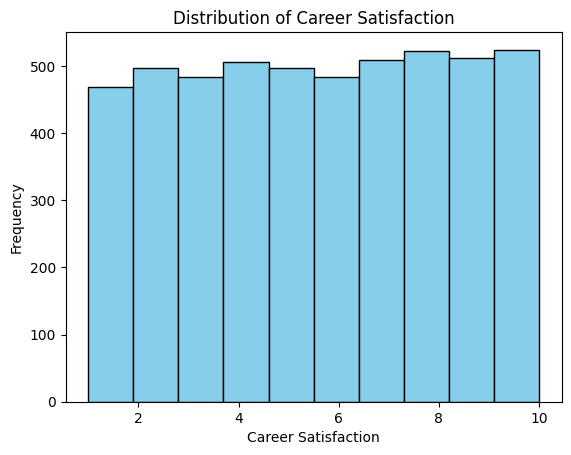

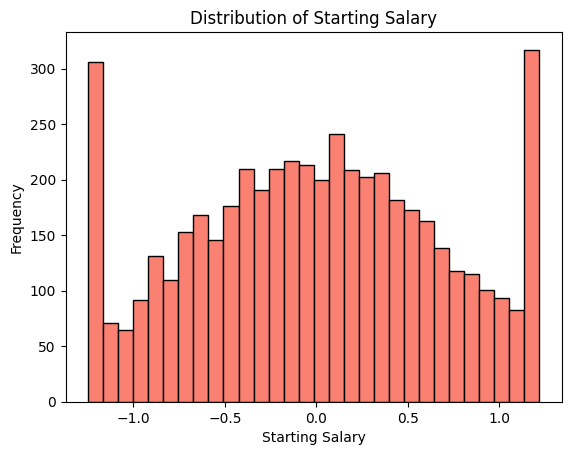

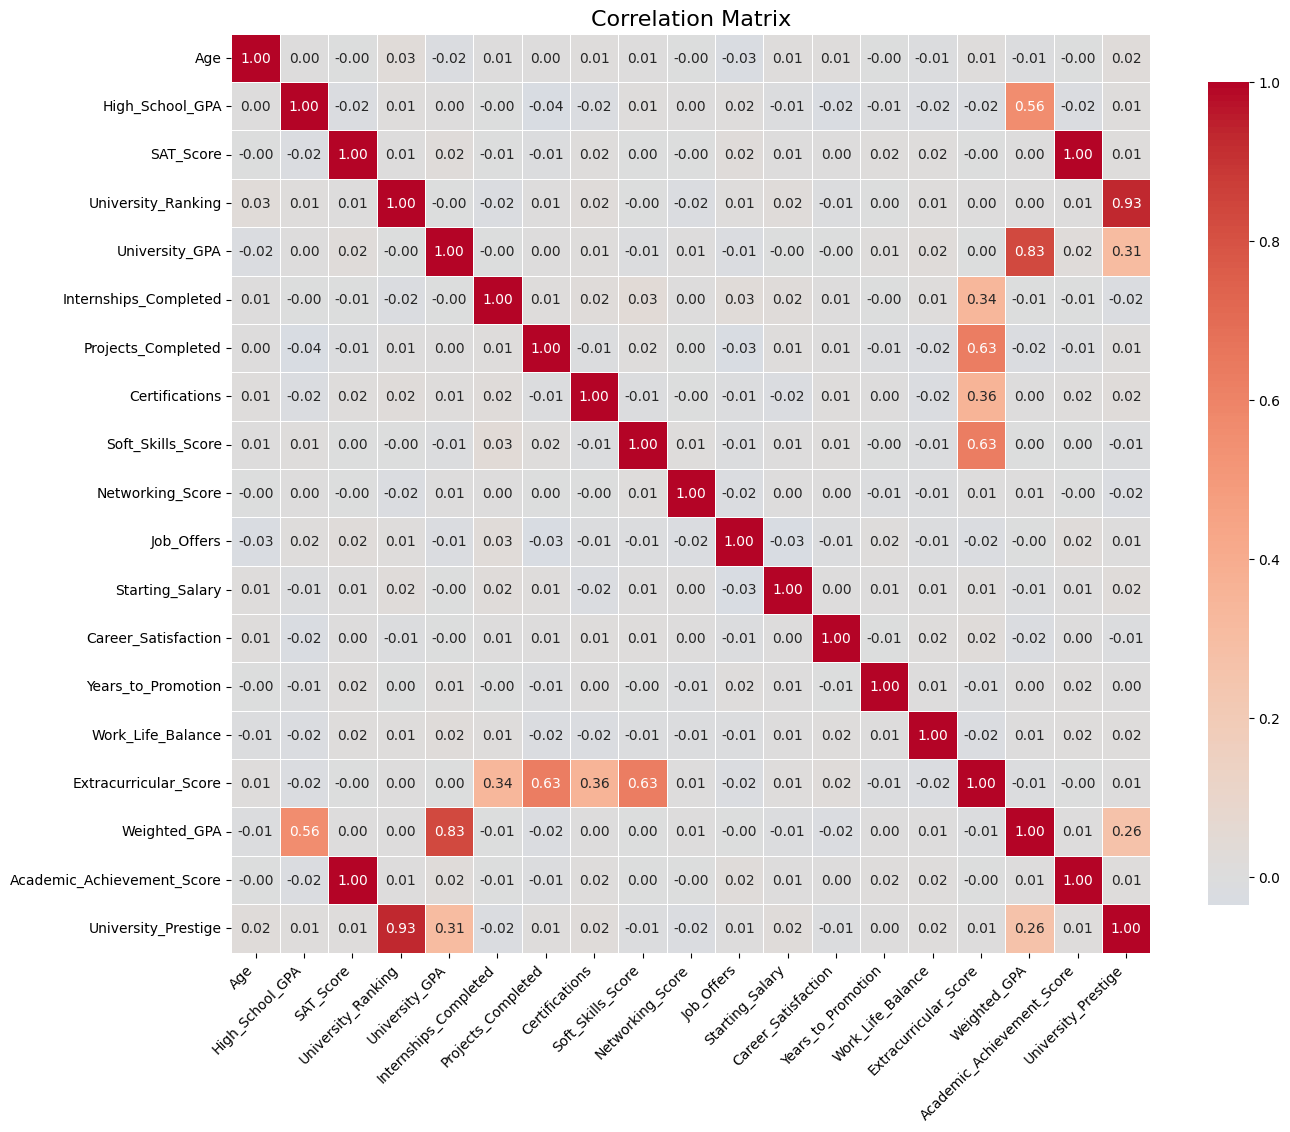

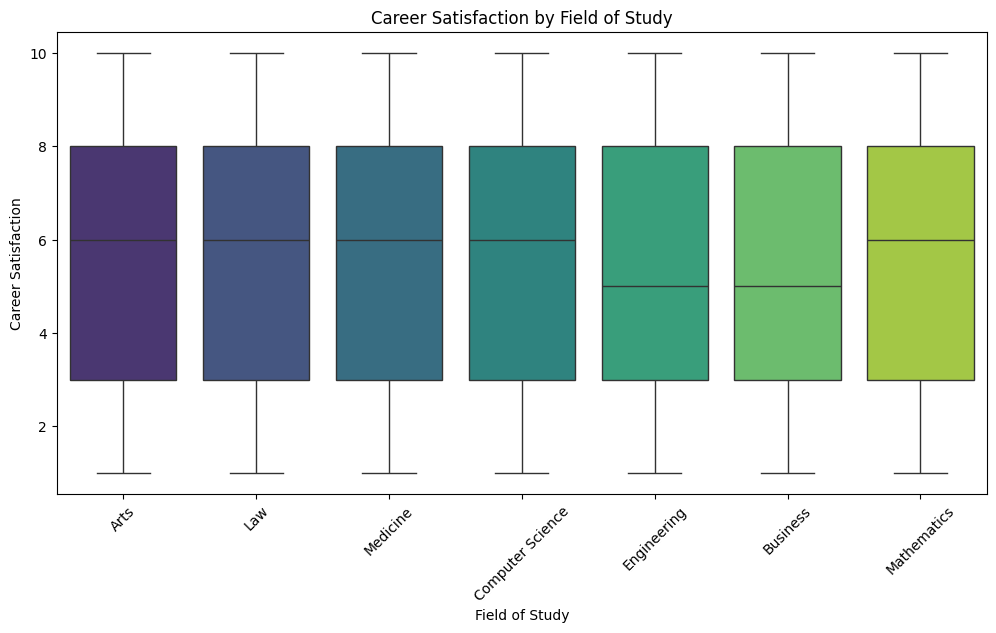

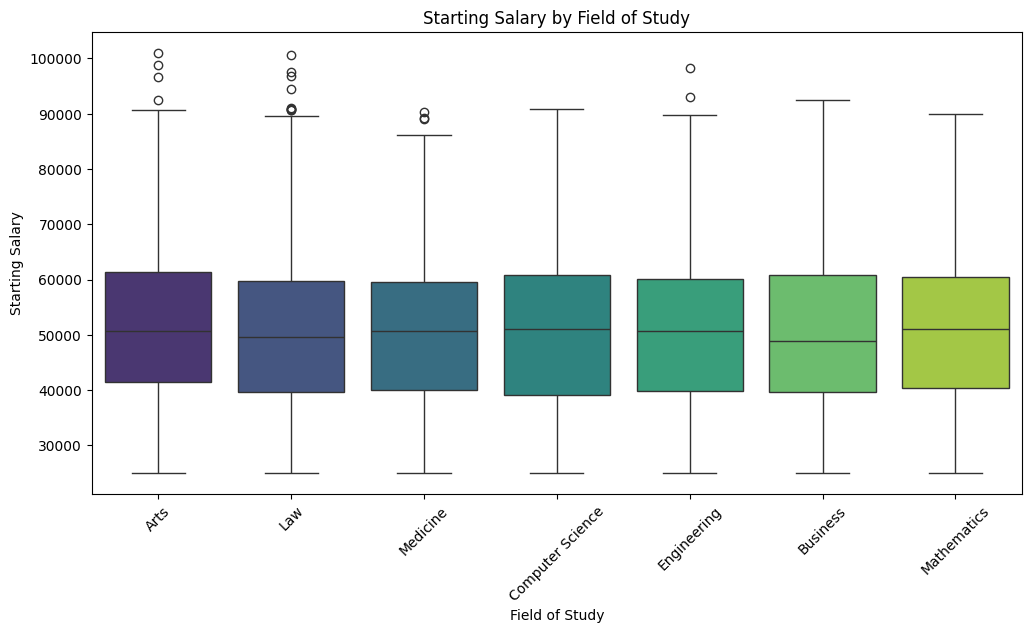

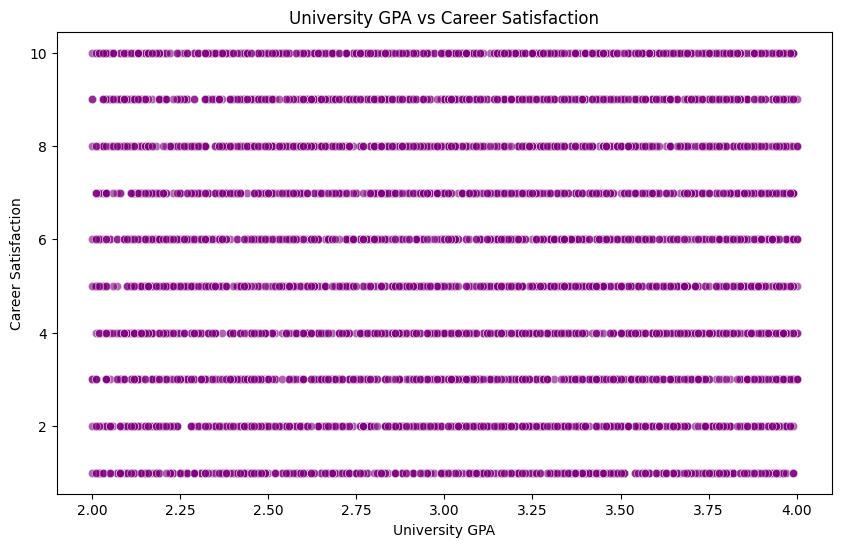

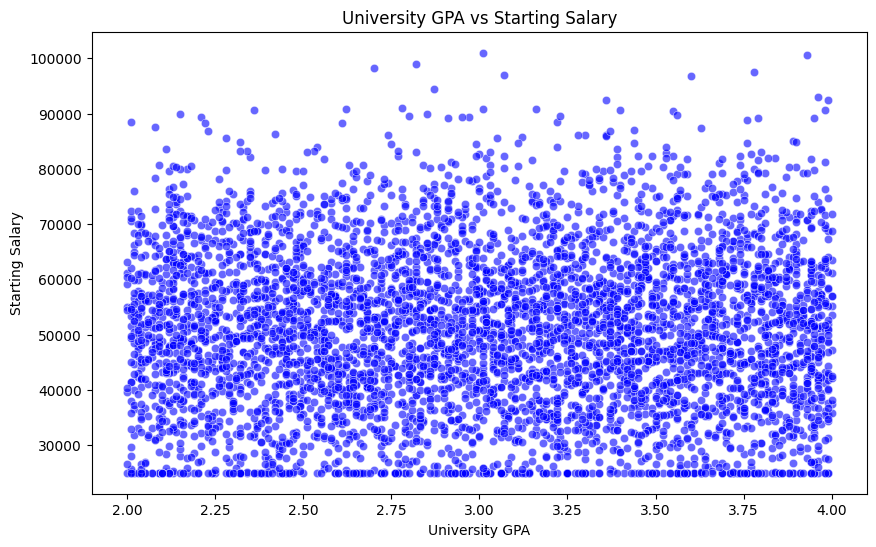

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("education_career_success.csv")

# Histogram of 'Career_Satisfaction'
plt.hist(data['Career_Satisfaction'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Career Satisfaction')
plt.ylabel('Frequency')
plt.title('Distribution of Career Satisfaction')
plt.show()

# Histogram of 'Starting_Salary'
## Drop NaN values from 'Starting_Salary' before plotting
starting_salary_cleaned = df_processed['Starting_Salary'].dropna()
plt.hist(starting_salary_cleaned, bins=30, color='salmon', edgecolor='black')
plt.xlabel('Starting Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Starting Salary')
plt.show()

# Compute the correlation matrix
numeric_df_processed = df_processed.select_dtypes(include=[np.number])
corr_matrix = numeric_df_processed.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, 
            cbar_kws={'shrink': 0.8}, linewidths=0.5, square=True)
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Boxplots of 'Career_Satisfaction' by 'Field_of_Study'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Field_of_Study', y='Career_Satisfaction', data=df, palette='viridis', hue='Field_of_Study', dodge=False)
plt.title('Career Satisfaction by Field of Study')
plt.xlabel('Field of Study')
plt.ylabel('Career Satisfaction')
plt.xticks(rotation=45)
plt.show()

# Boxplots of 'Starting_Salary' by 'Field_of_Study'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Field_of_Study', y='Starting_Salary', data=df, palette='viridis', hue='Field_of_Study', dodge=False)
plt.title('Starting Salary by Field of Study')
plt.xlabel('Field of Study')
plt.ylabel('Starting Salary')
plt.xticks(rotation=45)
plt.show()

# Scatter plot of 'University_GPA' vs 'Career_Satisfaction'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='University_GPA', y='Career_Satisfaction', data=df, alpha=0.6, color='purple')
plt.title('University GPA vs Career Satisfaction')
plt.xlabel('University GPA')
plt.ylabel('Career Satisfaction')
plt.show()

# Scatter plot of 'University_GPA' vs 'Starting_Salary'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='University_GPA', y='Starting_Salary', data=df, alpha=0.6, color='blue')
plt.title('University GPA vs Starting Salary')
plt.xlabel('University GPA')
plt.ylabel('Starting Salary')
plt.show()


## Baseline Neural Network Implementation

A neural network is a network of interconnected "neurons" (like the human brain) that work together to learn patterns. I'll feed it data, and it adjusts to the connections between the neurons to make better predictions. I'll be teaching my model to recognize complex relationshihps in data, even when those relationships aren't obvious.

#### Why a Neural Network?
**Complex Relationship**

My data, based on the correlation matrix, has subtle, non-linear relationships. A neural network excels at capturing the complexities which simplier models missed.

**Feature Interactions**

Neural networks can learn from how different features interact with each other, which is crucial when you have many factors influencing career success.

**Generalization**

With proper training and regularization, neural networks can generalize obvious and underlying data, allowing for them to make accurate predictions on new inputs. Because career success is likely influenced by a lot of different factors that don't have a simple, straight line relationshiop with each other, a neural network can learn and capture those complex relationships.

In [15]:
import pandas as pd
import numpy as np
import keras_tuner as kt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the processed data
df_processed_career = pd.read_csv('education_career_success_career_processed.csv')
df_processed_salary = pd.read_csv('education_career_success_salary_processed.csv')

# Separate features and targets (Career Satisfaction)
X_career = df_processed_career.drop('Career_Satisfaction', axis=1)
y_career = df_processed_career['Career_Satisfaction']

# Separate features and targets (Starting Salary)
X_salary = df_processed_salary.drop('Starting_Salary', axis=1)
y_salary = df_processed_salary['Starting_Salary']

# Train-test split
X_train_career, X_test_career, y_train_career, y_test_career = train_test_split(
    X_career, y_career, test_size=0.2, random_state=42
)
X_train_salary, X_test_salary, y_train_salary, y_test_salary = train_test_split(
    X_salary, y_salary, test_size=0.2, random_state=42
)  

# Neural Network Model for Career Satisfaction
model_career = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_career.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  
])
model_career.compile(optimizer='adam', loss='mean_squared_error')

# Neural Network Model for Starting Salary
model_salary = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_salary.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  
])
model_salary.compile(optimizer='adam', loss='mean_squared_error')

# Train the models
career_history = model_career.fit(X_train_career, y_train_career, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
salary_history = model_salary.fit(X_train_salary, y_train_salary, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the models
y_pred_career = model_career.predict(X_test_career).flatten()
y_pred_salary = model_salary.predict(X_test_salary).flatten()

# Metrics
mse_career = mean_squared_error(y_test_career, y_pred_career)
mae_career = mean_absolute_error(y_test_career, y_pred_career)
r2_career = r2_score(y_test_career, y_pred_career)

mse_salary = mean_squared_error(y_test_salary, y_pred_salary)
mae_salary = mean_absolute_error(y_test_salary, y_pred_salary)
r2_salary = r2_score(y_test_salary, y_pred_salary)

print("Career Satisfaction Model Metrics:")
print(f"MSE: {mse_career:.2f}, MAE: {mae_career:.2f}, R2: {r2_career:.2f}")

print("\nStarting Salary Model Metrics:")
print(f"MSE: {mse_salary:.2f}, MAE: {mae_salary:.2f}, R2: {r2_salary:.2f}")

Epoch 1/100


/Users/samuelbond/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.3761 - val_loss: 0.3449
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.3424 - val_loss: 0.3427
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.3265 - val_loss: 0.3426
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 0.3282 - val_loss: 0.3425
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.3183 - val_loss: 0.3430
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.3176 - val_loss: 0.3407
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.3200 - val_loss: 0.3380
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.3097 - val_loss: 0.3419
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.3119 - val_loss: 0.3420
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.3021 - val_loss: 0.3417
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.3112 - val_loss: 0.3425
Epoch 12/100
100/100 ━━━━━━━━━━

## Second Iteration: Neural Network

I've re-written the neural network to predict Career_Satisfaction and Starting_Salary simultaneously. I aim to improve it's efficiency and potentially capture new corraltions between the two. For hyperparameter tuning, I'm using Keras Tuner to refine the model's architecture and learing rate. The evaulation metrics are MSE, MAE, and R^2. 

In [16]:
import pandas as pd
import numpy as np
import keras_tuner as kt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
df_processed_career = pd.read_csv('education_career_success_career_processed.csv')
df_processed_salary = pd.read_csv('education_career_success_salary_processed.csv')

# Separate features and targets (Career Satisfaction)
X_career = df_processed_career.drop('Career_Satisfaction', axis=1)
y_career = df_processed_career['Career_Satisfaction']

# Separate features and targets (Starting Salary)
X_salary = df_processed_salary.drop('Starting_Salary', axis=1)
y_salary = df_processed_salary['Starting_Salary']

# Train-test split
X_train_career, X_test_career, y_train_career, y_test_career = train_test_split(
    X_career, y_career, test_size=0.2, random_state=42
)
X_train_salary, X_test_salary, y_train_salary, y_test_salary = train_test_split(
    X_salary, y_salary, test_size=0.2, random_state=42
)

# Hyperparameter Tuning for Career Satisfaction
def model_builder_career(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train_career.shape[1],)))
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the number of Dense layers
    hp_layers = hp.Int('layers', min_value=2, max_value=5)
    for _ in range(hp_layers):
        model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(1))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model

# Hyperparameter Tuning for Starting Salary
def model_builder_salary(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train_salary.shape[1],)))
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the number of Dense layers
    hp_layers = hp.Int('layers', min_value=2, max_value=5)
    for _ in range(hp_layers):
        model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(1))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model

# Keras Tuner for Career Satisfaction
tuner_career = kt.Hyperband(model_builder_career, 
                            objective='val_loss', 
                            max_epochs=20, 
                            factor=3, 
                            directory='career_tuning', 
                            project_name='career_satisfaction_tuning')

tuner_career.search(X_train_career, y_train_career, 
                    epochs=100, validation_split=0.2, 
                    verbose=1)

# Keras Tuner for Starting Salary
tuner_salary = kt.Hyperband(model_builder_salary, 
                            objective='val_loss', 
                            max_epochs=10, factor=3, 
                            directory='salary_tuning', 
                            project_name='starting_salary_tuning')

tuner_salary.search(X_train_salary, y_train_salary, 
                    epochs=100, 
                    validation_split=0.2, 
                    verbose=1)

# Get teh best models
best_model_career = tuner_career.get_best_models(num_models=1)[0]
best_model_salary = tuner_salary.get_best_models(num_models=1)[0]

# Evaluate the models
y_pred_career = best_model_career.predict(X_test_career).flatten()
y_pred_salary = best_model_salary.predict(X_test_salary).flatten()

# Metrics (Career)
mse_career = mean_squared_error(y_test_career, y_pred_career)
mae_career = mean_absolute_error(y_test_career, y_pred_career)
r2_career = r2_score(y_test_career, y_pred_career)

# Metrics (Salary)
mse_salary = mean_squared_error(y_test_salary, y_pred_salary)
mae_salary = mean_absolute_error(y_test_salary, y_pred_salary)
r2_salary = r2_score(y_test_salary, y_pred_salary)

print("Career Satisfaction Model Metrics:")
print(f"MSE: {mse_career:.2f}, MAE: {mae_career:.2f}, R2: {r2_career:.2f}")

print("\nStarting Salary Model Metrics:")
print(f"MSE: {mse_salary:.2f}, MAE: {mae_salary:.2f}, R2: {r2_salary:.2f}")

Reloading Tuner from career_tuning/career_satisfaction_tuning/tuner0.json
Reloading Tuner from salary_tuning/starting_salary_tuning/tuner0.json


/Users/samuelbond/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/samuelbond/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Career Satisfaction Model Metrics:
MSE: 0.35, MAE: 0.51, R2: -0.03

Starting Salary Model Metrics:
MSE: 0.48, MAE: 0.57, R2: -0.01


/Users/samuelbond/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Model Visualizations

This is done to evaluate the neural network's approach to identifying the complex network of relationships between academic performance and career satisfaction. The model's strengths were compared through these visualizations. 


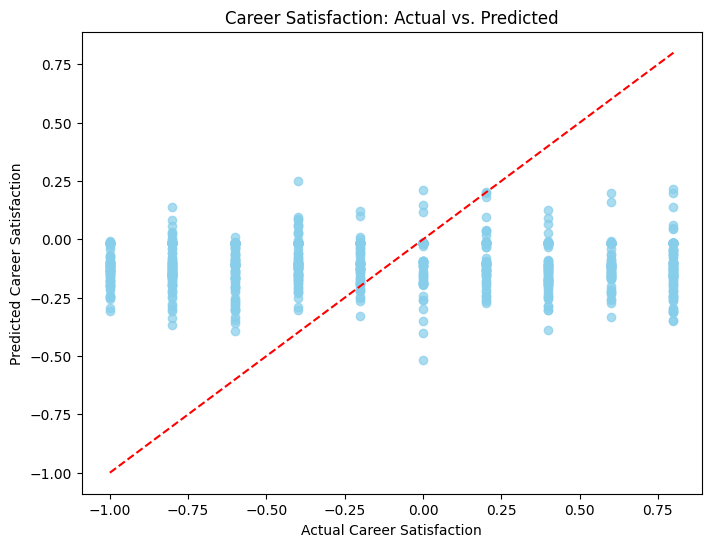

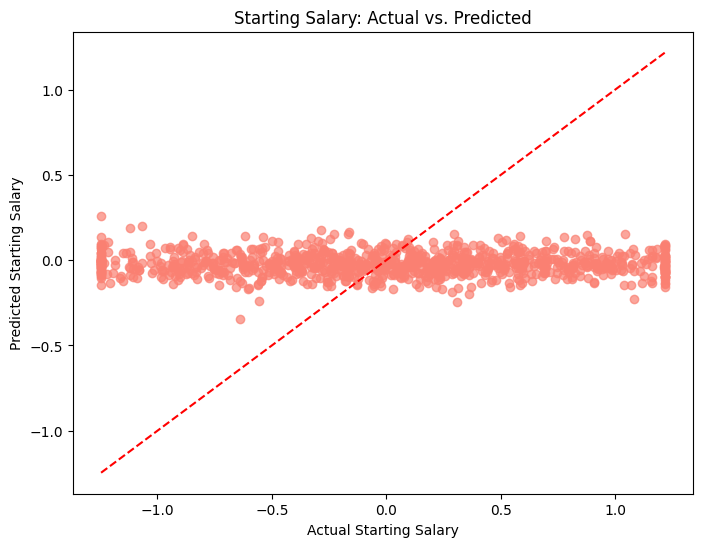

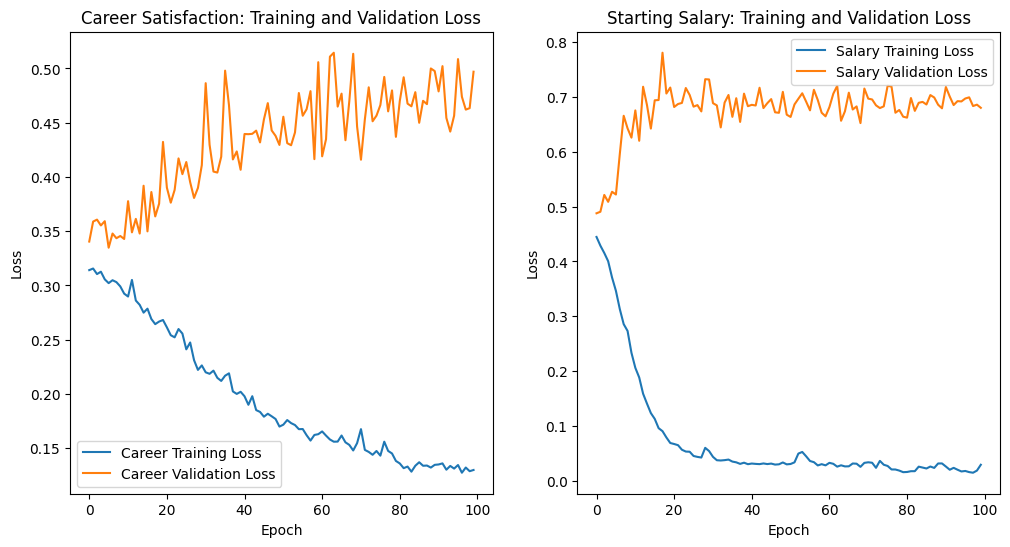


Model Strengths and Weaknesses:
- Strengths:
  - Ability to capture non-linear relationships between academic performance and career success.
  - Hyperparameter tuning with Keras Tuner allows for optimization of model architecture and training process.
- Weaknesses:
  - Potential for overfitting, especially with complex architectures.
  - Difficulty in interpreting the model's decision-making process.
  - Performance might be limited by the quality and relevance of the input features.


In [ ]:
# Plotting Predicted vs. Actual for Career Satisfaction
plt.figure(figsize=(8, 6))
plt.scatter(y_test_career, y_pred_career, color='skyblue', alpha=0.7)
plt.plot([min(y_test_career), max(y_test_career)],
         [min(y_test_career), max(y_test_career)],
         linestyle='--',
         color='red')  # Ideal prediction line
plt.xlabel('Actual Career Satisfaction')
plt.ylabel('Predicted Career Satisfaction')
plt.title('Career Satisfaction: Actual vs. Predicted')
plt.show()

# Plotting Predicted vs. Actual for Starting Salary
plt.figure(figsize=(8, 6))
plt.scatter(y_test_salary, y_pred_salary, color='salmon', alpha=0.7)
plt.plot([min(y_test_salary), max(y_test_salary)],
         [min(y_test_salary), max(y_test_salary)],
         linestyle='--',
         color='red')  # Ideal prediction line
plt.xlabel('Actual Starting Salary')
plt.ylabel('Predicted Starting Salary')
plt.title('Starting Salary: Actual vs. Predicted')
plt.show()

# Plotting Loss Curves (using history from fitting the best models)
history_career = best_model_career.fit(X_train_career, y_train_career, epochs=100, validation_split=0.2, verbose=0)
history_salary = best_model_salary.fit(X_train_salary, y_train_salary, epochs=100, validation_split=0.2, verbose=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_career.history['loss'], label='Career Training Loss')
plt.plot(history_career.history['val_loss'], label='Career Validation Loss')
plt.title('Career Satisfaction: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_salary.history['loss'], label='Salary Training Loss')
plt.plot(history_salary.history['val_loss'], label='Salary Validation Loss')
plt.title('Starting Salary: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()